# Understand how formulas from papers work

Quote from paper:
What distinguishes diffusion models from other types of latent variable models is that the approximate posterior q(x1:T |x0), called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β1 , . . . , βT:

$q(x_{1:T} |x_0) := \prod_{t=1}^n q(x_t|x_t−1)$ <br/>
$q(x_t|x_{t−1}) := \mathcal{N}(x_t, \sqrt{1 − β_t}x_{t−1}, β_tI)$

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import numpy as np
import utils

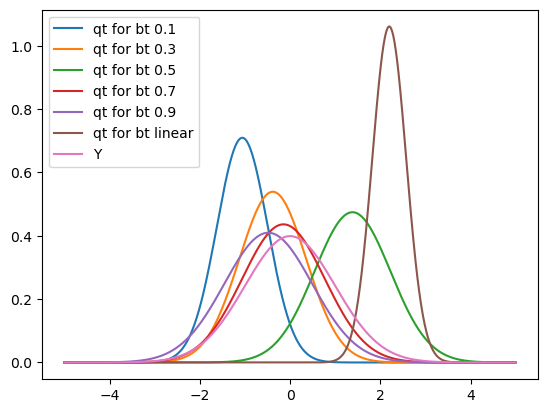

In [184]:
# Implement q function with 1 dimensional argument
# We have to fix a seed to get the same results

# Fix a seed to get the same results
utils.seed_everything(1000)

# Number of timesteps
timestep = 1000

# Our interval
xs = np.arange(-5, 5, 0.01)

# Apply normal pdf to xs with 0 mean and 1 variance (Just to check graph with our graphs)
y_results = norm.pdf(xs, 0, 1)

different_schedules = [
    # constant
    np.ones(timestep) * 0.1,
    np.ones(timestep) * 0.3,
    np.ones(timestep) * 0.5,
    np.ones(timestep) * 0.7,
    np.ones(timestep) * 0.9,
    # linear change (from paper)
    np.linspace(1e-4, 0.02, timestep)
]

# set x0 some random value from -1 to 1
x0 = np.random.uniform(-1,1)

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = math.sqrt(bt[t])

        # Q is a normal distribution, so to get the next xt, we just get random element from our distribution
        xt = np.random.normal(mean, math.sqrt(variance))

    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

In previous code we have a line:

`xt = np.random.normal(mean, math.sqrt(variance))`

Which means we always get some random variable. If we want to make a backpropagation in the future, it's hard to do it, because we can not make deriviative $x_t$ by $x_{t-1}$.
To avoid this situation lets make reparametrization trick.

$x_t \sim q(x_t | x_{t-1}) := \mathcal{N}(x_t, \mu_{t-1}, \delta_{t-1} ^2 ) $ <br/>
$x_t = \mu_{t-1} + \delta_{t-1} * \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

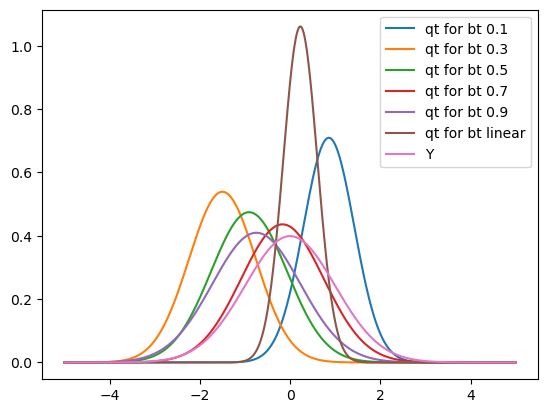

In [178]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = math.sqrt(bt[t])

        # Get eps from normal distribution
        eps = np.random.normal(0, 1)
        
        # Calculate our xt
        xt = mean + variance * eps

    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

We got the same view of graphs with some offset by x position (difference in a random variable).

Right now we have a direct formula to compute $x_t$. When we are working in one dimensional, it's so easy and fast to compute $x_t$, but if we want to work in 100D, 1000D, 10000D, etc. our loop will be a big pain and have a bad performance.

Can we avoid our timestep loop? Let's go to formulas

$\alpha_t = 1 - \beta_t, \bar \alpha_t = \prod_{i=1}^t\alpha_i$ <br/>
$x_t = \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t = \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1})} * \epsilon_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t$

$\epsilon_t \sim \mathcal{N}(0, \delta_t^2 I)$ and $\epsilon_{t-1} \sim \mathcal{N}(0, \delta_{t-1}^2 I)$. So their merge will be $\mathcal{N}(0, (\delta_t^2 + \delta_{t-1}^2)I)$. Rewrite the formula above:

$x_t=\sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1}) + 1 - \alpha_t} * \bar{\epsilon_{t-2}} = \sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t * \alpha_{t-1}} * \bar{\epsilon_{t-2}}$ <br/>

And then we can continue this line until we reach x0: <br/>
$x_t=\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}$

Lets try to implement it and compare results with previous graphs.

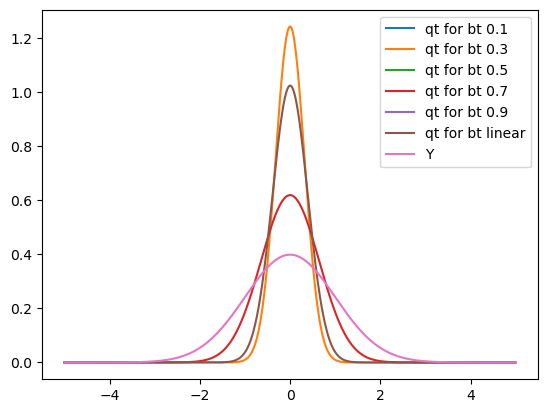

In [187]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:
    alpha_t = 1 - bt
    cumprod_alpha_t = np.cumprod(alpha_t)
    mean = math.sqrt(cumprod_alpha_t[-1]) * x0
    variance = math.sqrt(1 - cumprod_alpha_t[-1])
    eps = np.random.normal(0, 1)

    q_results = norm.pdf(xs, mean, variance * eps)
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

In [91]:
import torch

def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  betas = torch.cat((torch.tensor([0]), betas))
  return betas

def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

In [92]:
import requests
from PIL import Image

url = 'https://images.pexels.com/photos/1557208/pexels-photo-1557208.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)
# image

In [201]:
from torchvision.transforms import RandomHorizontalFlip, Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 64
transform = Compose([
  Resize((image_size, image_size)),
  # CenterCrop(image_size),
  RandomHorizontalFlip(),
  ToTensor(),
  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

x0 = transform(image).unsqueeze(0)
# plt.imshow(transform(image).permute(1,2,0))

tensor(0.0064)
tensor([[[[0.9992]]]])


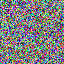

In [226]:
x0 = transform(image).unsqueeze(0)

def sample_by_t(tensor_to_sample, timesteps, x_shape):
    batch_size = timesteps.shape[0]
    sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
    sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
    return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    print(sqrt_alphas_bar_t[-1])
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    print(sqrt_1_minus_alphas_bar_t_sampled)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t

def get_noisy_image(x0, t, transform=reverse_transform_pil):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image

t = torch.tensor([800])
get_noisy_image(x0, t)

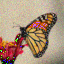

In [202]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

num_timesteps = 1000
betas_t = linear_schedule(num_timesteps)

alphas_t = 1. - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_t = torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_alphas_bar_t_minus_1 = torch.sqrt(alphas_bar_t_minus_1)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)
# the variance of q(xₜ₋₁ | xₜ, x₀) as in part 3
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t
     

def get_noisy_image(x0, t, transform=reverse_transform_pil):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image
     

import matplotlib.pyplot as plt
def show_noisy_images(noisy_images):
    num_of_image_sets = len(noisy_images)
    num_of_images_in_set = len(noisy_images[0])
    image_size = noisy_images[0][0].size[0]

    full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
    for set_index, image_set in enumerate(noisy_images):
        for image_index, image in enumerate(image_set):
            full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))

    plt.imshow(full_image)
    plt.axis('off')
    return full_image

t = torch.tensor([20])

get_noisy_image(x0, t)

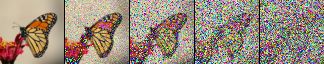

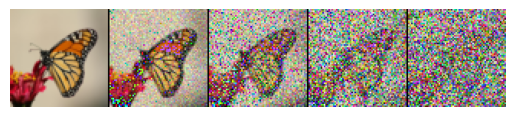

In [129]:
show_noisy_images([[get_noisy_image(x0, torch.tensor([t])) for t in [0, 50, 100, 150, 200]]])
